In [1]:
import numpy as np
import skeliner as sk

import matplotlib.pyplot as plt

This notebook shows how to find contact sites between two neurons from Eyewire II. 

We will first find all putative contact locations with the skeletons (assuming the node radii are robustly estimated). Next, we will cluster putative contact locations, and try approximating their contact areas with the skeleton informations. At last, we will use the seeds to extract the contact site faces from the corresponding meshes, and calculate the area of all contact sites. 

### Find contact seeds between skeleton A and B

In [2]:
dsgc = sk.io.load_npz("../../data/DSGC/720575940567182923/skeleton.npz")
sac_off = sk.io.load_npz("../../data/SAC-OFF/720575940572154471/skeleton.npz")

In [3]:
contact_seeds = sk.pair.find_contact_seeds(dsgc, sac_off)

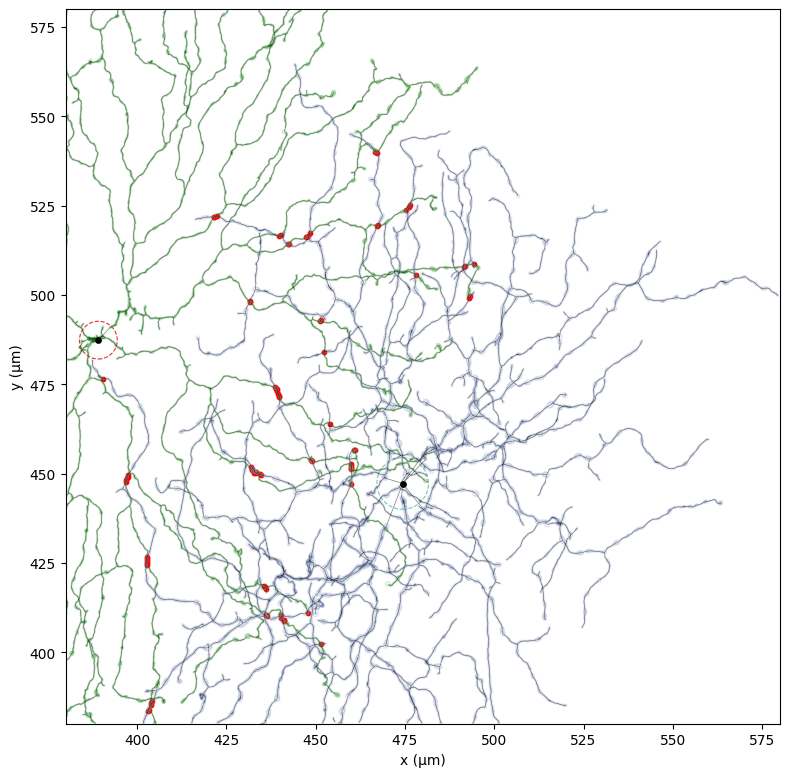

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sk.plot2d(sac_off, color_by="ntype", skel_cmap="Set1", ax=ax, xlim=(380, 580), ylim=(380, 580))
sk.plot2d(dsgc, color_by="ntype", skel_cmap="Set2", ax=ax, xlim=(380, 580), ylim=(380, 580))

plt.scatter(contact_seeds.pos[:, 0], contact_seeds.pos[:, 1], color="red", s=10)


### Clustering the seeds and approximating the contact areas with the skeletons only

In [5]:
approx = sk.pair.approximate_sites_from_seeds(
    dsgc, sac_off, seeds=contact_seeds,
    tol_nm=54, # from experience, this value is mostly around 50-55 for Eyewire II                   
    area_unit="um^2",
)
print(f"# approximated contact sites: {approx.meta['K_sites']}, total area: {approx.area_A.sum()}")

# approximated contact sites: 36, total area: 13.969447591262233


In [6]:
approx.area_A

array([0.95437008, 0.44767254, 0.47817213, 0.27735202, 0.22870374,
       0.58991813, 0.15027153, 0.06636874, 0.08696895, 0.09183636,
       0.83517347, 0.23353446, 0.38754602, 0.58225878, 0.84442311,
       1.22924558, 0.73204994, 0.17684512, 0.42953382, 1.04141389,
       0.1322453 , 0.25681207, 0.28054705, 0.24160431, 0.24965848,
       0.0502339 , 0.19564626, 0.1759574 , 0.38180336, 0.13400265,
       0.23964405, 0.05267742, 0.16543826, 0.32733879, 0.81358681,
       0.40859306])

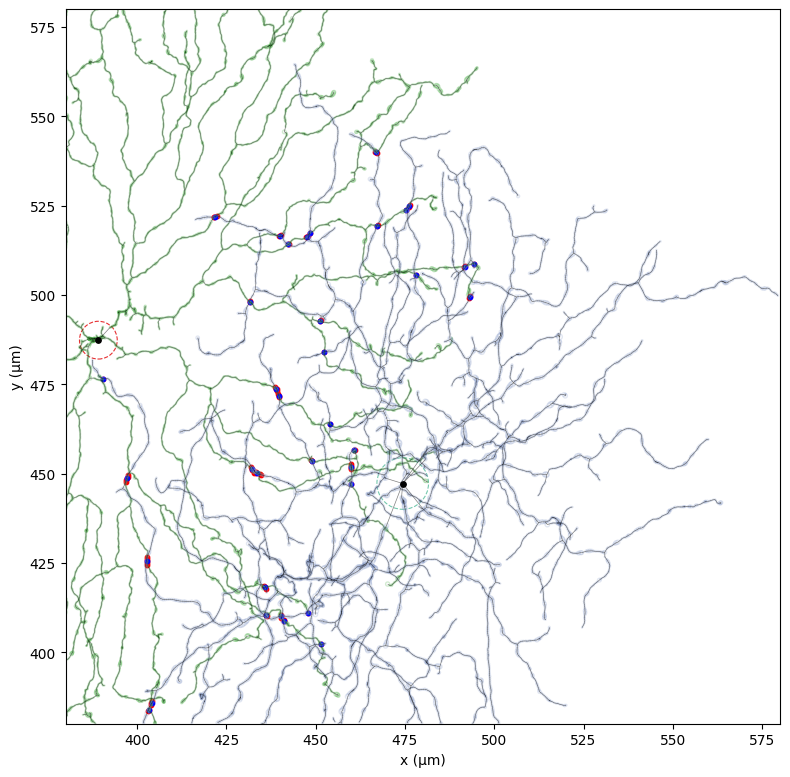

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sk.plot2d(sac_off, color_by="ntype", skel_cmap="Set1", ax=ax, xlim=(380, 580), ylim=(380, 580))
sk.plot2d(dsgc, color_by="ntype", skel_cmap="Set2", ax=ax, xlim=(380, 580), ylim=(380, 580))

plt.scatter(contact_seeds.pos[:, 0], contact_seeds.pos[:, 1], color="red", s=10)
plt.scatter(approx.center[:, 0], approx.center[:, 1], color="blue", s=10)

### Using the seeds to find contact sites on mesh A and B

In [8]:
dsgc_mesh = sk.io.load_mesh("../../data/DSGC/720575940567182923/mesh.obj")
sac_off_mesh = sk.io.load_mesh("../../data/SAC-OFF/720575940572154471/mesh.obj")

contact_sites = sk.pair.map_contact_sites(
    dsgc_mesh, sac_off_mesh, 
    contact_seeds.pos * 1000.0 # unit: nm
)

print(f"# approximated contact sites: {len(contact_sites.area_A)}, total area: {contact_sites.area_A.sum() * 1e-6} um^2")

# approximated contact sites: 32, total area: 13.928256023442204 um^2


In [9]:
contact_sites.area_A * 1e-6

array([1.15394108, 0.70949342, 0.74908076, 0.88683408, 0.69671071,
       0.04776205, 0.22110228, 0.11470915, 0.44173302, 1.0064391 ,
       0.32966614, 0.3376796 , 0.22335312, 0.80127101, 1.57423554,
       0.16925257, 0.52331199, 0.52446789, 0.17649908, 0.07302392,
       0.11372621, 0.19136563, 0.20633399, 0.25721735, 0.20402571,
       0.73951546, 0.22925671, 0.04008333, 0.0193548 , 0.25746198,
       0.43475128, 0.47459707])

In [10]:
print(f"# contact seeds: {len(contact_seeds.pos)}")
print(f"# approximated contact sites: {len(approx.center)}, total area = {approx.area_A.sum()} um^2")
print(f"# contact sites: {len(contact_sites.seeds_A)}, total area = {contact_sites.area_A.sum() * 1e-6} um^2")

# contact seeds: 82
# approximated contact sites: 36, total area = 13.969447591262233 um^2
# contact sites: 32, total area = 13.928256023442204 um^2


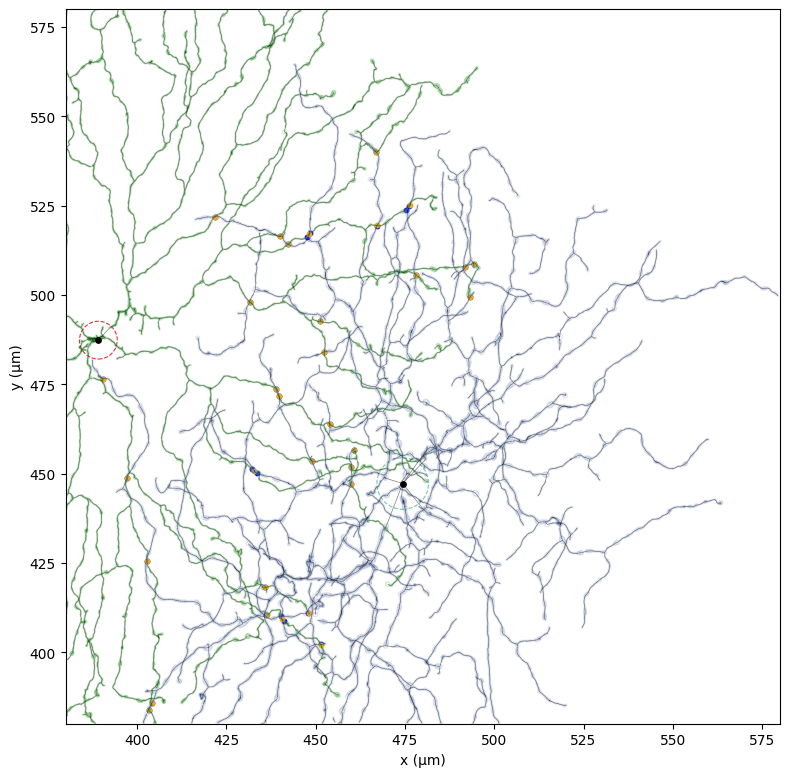

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sk.plot2d(sac_off, color_by="ntype", skel_cmap="Set1", ax=ax, xlim=(380, 580), ylim=(380, 580))
sk.plot2d(dsgc, color_by="ntype", skel_cmap="Set2", ax=ax, xlim=(380, 580), ylim=(380, 580))

plt.scatter(approx.center[:, 0], approx.center[:, 1], color="blue", s=10)
plt.scatter(contact_sites.seeds_A[:, 0]/1000, contact_sites.seeds_A[:, 1]/1000, color="orange", s=10)


In [12]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-08-30 17:15:23CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

numpy     : 2.0.2
skeliner  : 0.1.11
matplotlib: 3.10.3

Watermark: 2.5.0

